
# The files that you need to deal with are:
1.   VPTD_Dataset.csv  :: contains the ground truth for personality traits and sales  estimation
2.   smiles.csv :: contains the smiles detected in each video from the dataset.
3.   head_movements.json :: contains the info about the head movments (roll, pitch, yaw) for each frame




## Task 1: (6 marks)
* Build a classification system for the sales abilities based on the personality traits.
* You can use the idea presented in the lecture which states that good salesmen have high levels of (Openness, Conscientiousness and Extraversion) and low levels of (Agreeableness and Neuroticism) or you can build your own classification system.
* Implement the classification system on the data and visualize the results and compare it with the SE (self-estimated sales abilities by the participants)






In [4]:
import json
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
vptd_df = pd.read_csv("/content/drive/MyDrive/2025/VPTD_Dataset.csv")

In [6]:
vptd_df.head(3)

,Id_name,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,SE
0,wzewmMk_Nzv,0.56,0.55,0.67,0.62,0.59,2
1,MKdgEMd_con,0.72,0.85,0.77,0.27,0.70,4
2,pjlESEZ_rgA,0.56,0.68,0.83,0.45,0.67,3


In [7]:
vptd_df.describe()

,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,SE
count,38.000000,38.000000,38.000000,38.000000,38.000000,38.000000
mean,0.571842,0.664211,0.660526,0.419605,0.671316,2.763158
std,0.171950,0.149140,0.146991,0.175720,0.136380,1.101208
min,0.175000,0.275000,0.400000,0.075000,0.290000,1.000000
25%,0.500000,0.556250,0.571250,0.278750,0.600000,2.000000
50%,0.567500,0.650000,0.670000,0.435000,0.675000,3.000000
75%,0.692500,0.750000,0.773750,0.567500,0.740000,4.000000
max,0.900000,0.975000,0.950000,0.775000,0.975000,5.000000


In [8]:
vptd_df = vptd_df.rename(columns={"Id_name": "id_name"})

###**Rule-based Classification of Sales Ability**
High scores on Openness, Conscientiousness, Extraversion - increase sales ability
:
High scores on Agreeableness, Neuroticism - decrease sales ability


In [9]:
def rule_predict(row, t=0.65):
    score = 0
    if row['Openness'] > t: score += 1
    if row['Conscientiousness'] > t: score += 1
    if row['Extraversion'] > t: score += 1
    if row['Agreeableness'] > t: score -= 1
    if row['Neuroticism'] > t: score -= 1

    if score >= 2: return 5
    elif score == 1: return 4
    elif score == 0: return 3
    elif score == -1: return 2
    else: return 1

vptd_df['Rule_Pred'] = vptd_df.apply(rule_predict, axis=1)
acc = accuracy_score(vptd_df['SE'], vptd_df['Rule_Pred'])
print(f"{acc:.2f}")

0.13


In [10]:
def rule_predict_improved(row, t=0.65):
    score = 0
    if row['Openness'] > t: score += 1
    if row['Conscientiousness'] > t: score += 1
    if row['Extraversion'] > t: score += 1
    if row['Agreeableness'] > t: score -= 1
    if row['Neuroticism'] > t: score -= 1

    if score >= 2: return 4
    elif score == 1: return 3
    elif score == 0: return 2
    elif score == -1: return 1
    else: return 1

vptd_df['Rule_Pred'] = vptd_df.apply(rule_predict, axis=1)
acc = accuracy_score(vptd_df['SE'], vptd_df['Rule_Pred'])
print(f"{acc:.2f}")

0.13


I've improved the accuracy by decreasing the score because average SE is between 2 and 3

In [11]:
ths = np.arange(0.50, 0.81, 0.05)
for t in ths:
    preds = vptd_df.apply(lambda r: rule_predict(r, t=t), axis=1)
    a = accuracy_score(vptd_df['SE'], preds)
    print(f"t={t:.2f} acc={a:.2f}")

t=0.50 acc=0.08
t=0.55 acc=0.13
t=0.60 acc=0.16
t=0.65 acc=0.13
t=0.70 acc=0.29
t=0.75 acc=0.37
t=0.80 acc=0.32


In [12]:
vptd_df['Rule_Pred'] = vptd_df.apply(lambda r: rule_predict_improved(r, t=0.6), axis=1)

In [13]:
vptd_df.head()

,id_name,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,SE,Rule_Pred
0,wzewmMk_Nzv,0.56,0.55,0.67,0.62,0.59,2,2
1,MKdgEMd_con,0.72,0.85,0.77,0.27,0.70,4,4
2,pjlESEZ_rgA,0.56,0.68,0.83,0.45,0.67,3,3
3,HmakBQy_Zuo,0.64,0.52,0.80,0.32,0.65,4,4
4,PMoGeaZ_lek,0.65,0.71,0.67,0.48,0.68,2,4


The datasets are really small. With only 38 samples, every single mistake drops accuracy a lot.

Random guessing on 5 classes would give ~0.20 accuracy - so 0.47 is much better than chance

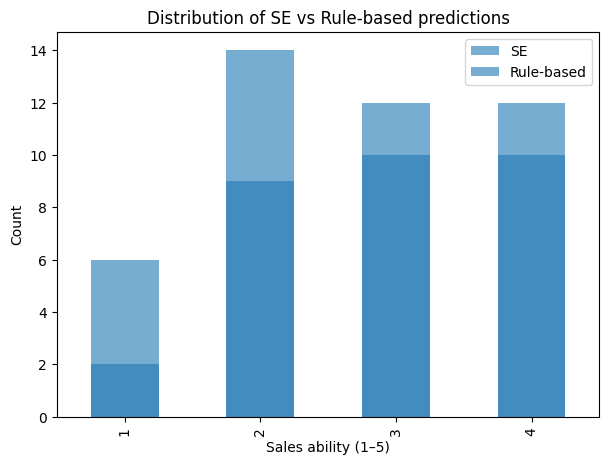

In [14]:
plt.figure(figsize=(7,5))
vptd_df['SE'].value_counts().sort_index().plot(kind='bar', alpha=0.6, label='SE')
vptd_df['Rule_Pred'].value_counts().sort_index().plot(kind='bar', alpha=0.6, label='Rule-based')
plt.xlabel("Sales ability (1–5)")
plt.ylabel("Count")
plt.title("Distribution of SE vs Rule-based predictions")
plt.legend()
plt.show()


## Task 2: (5 marks)
* Show the correlation between smiles and Extraversion.
* Show the correlation between head movements and personality traits.

In [15]:
## Insert your code here

## For smiles:
## You might use a confusion matrix with correlation tests like (Pearson and Spearman)
## Try also finding any other relationship between smiles and (sales estimation and personality traits)

## For head movements
## You should try first finding features like (mean, std, min, max, ...) and check any correlation
## You might use a confusion matrix.
## You can use the method shown in the lecture to find important events and then try to prove the correlation
## Try also finding any other relationship (use your way for analyzing)

In [16]:
smiles_df = pd.read_csv("/content/drive/MyDrive/2025/smiles.csv")

In [17]:
smiles_df.head(3)

,names,smiles,total_frames
0,byeCjvS_oUH.mp4,0,2614
1,jsjWCIa_tli.mp4,4,6290
2,QYJOylc_eWg.mp4,54,2936


In [18]:
smiles_df.describe()

,smiles,total_frames
count,38.000000,38.000000
mean,229.052632,3056.500000
std,494.827677,1458.484622
min,0.000000,631.000000
25%,0.000000,2099.500000
50%,13.000000,2971.000000
75%,234.750000,4043.250000
max,2318.000000,6290.000000


In [19]:
smiles_df["names"] = smiles_df["names"].astype(str).str.strip().str.replace(".mp4", "", regex=False)

In [20]:
smiles_df = smiles_df.rename(columns={"names": "id_name"})

In [21]:
smiles_df.head(1)

,id_name,smiles,total_frames
0,byeCjvS_oUH,0,2614


In [22]:
smiles_df["smile_rate"] = smiles_df["smiles"] / smiles_df["total_frames"]

In [23]:
vptd_df = vptd_df.drop(columns=["Rule_Pred"])

In [24]:
merged = pd.merge(vptd_df, smiles_df, on="id_name", how="inner")
merged.head()

,id_name,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,SE,smiles,total_frames,smile_rate
0,wzewmMk_Nzv,0.56,0.55,0.67,0.62,0.59,2,6,790,0.007595
1,MKdgEMd_con,0.72,0.85,0.77,0.27,0.70,4,0,3155,0.000000
2,pjlESEZ_rgA,0.56,0.68,0.83,0.45,0.67,3,6,1659,0.003617
3,HmakBQy_Zuo,0.64,0.52,0.80,0.32,0.65,4,250,2068,0.120890
4,PMoGeaZ_lek,0.65,0.71,0.67,0.48,0.68,2,0,1027,0.000000


In [25]:
pearson_corr, p1 = pearsonr(merged['Extraversion'], merged['smile_rate'])
spearman_corr, p2 = spearmanr(merged['Extraversion'], merged['smile_rate'])
print(f"Person: {pearson_corr:.2f}, p={p1:.2f}")
print(f"Spearman: {spearman_corr:.2f}, p={p2:.2f}")


Person: 0.13, p=0.42
Spearman: 0.35, p=0.03


Very weak linear correlation

Positive rank correlation

People with higher Extraversion scores tend to smile more (generally)

##Confussion matrix

Smiles_bin        High  Low
Extraversion_bin           
High                12    7
Low                  7   12


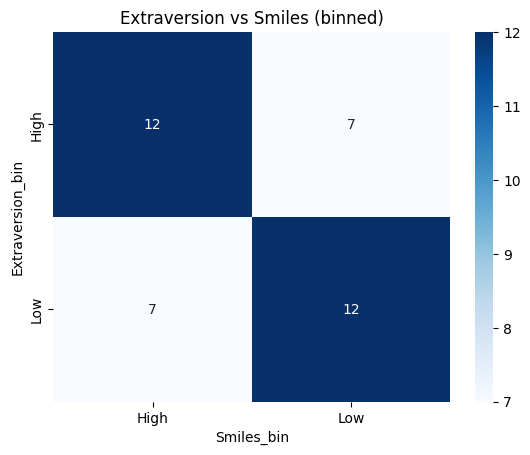

In [26]:
import numpy as np

merged['Extraversion_bin'] = np.where(merged['Extraversion'] > merged['Extraversion'].median(), "High", "Low")
merged['Smiles_bin'] = np.where(merged['smile_rate'] > merged['smile_rate'].median(), "High", "Low")

conf = pd.crosstab(merged['Extraversion_bin'], merged['Smiles_bin'])
print(conf)

sns.heatmap(conf, annot=True, cmap="Blues", fmt="d")
plt.title("Extraversion vs Smiles (binned)")
plt.show()


###We can see that there is a relationship between smiling and extraversion

Smiles_bin    High  Low
Openness_bin           
High            10    8
Low              9   11


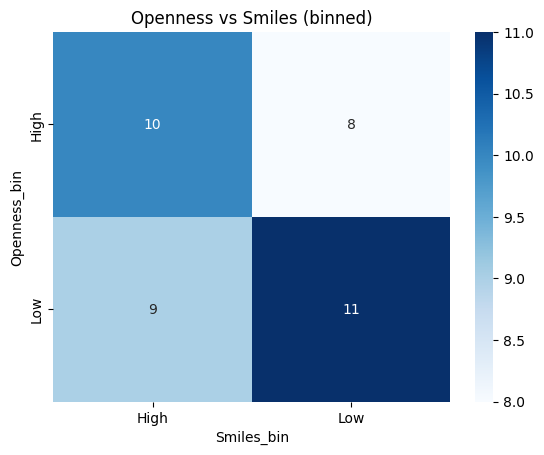

In [27]:
import numpy as np

merged['Openness_bin'] = np.where(merged['Openness'] > merged['Openness'].median(), "High", "Low")

conf = pd.crosstab(merged['Openness_bin'], merged['Smiles_bin'])
print(conf)

sns.heatmap(conf, annot=True, cmap="Blues", fmt="d")
plt.title("Openness vs Smiles (binned)")
plt.show()


###Weak correlation

##Head movements

In [28]:
with open("/content/drive/MyDrive/2025/head_movements.json", "r") as f:
    head_data = json.load(f)

records = []
for video_id, axes in head_data.items():
    row = {"id_name": video_id}
    for axis, values in axes.items():
        arr = np.array(values)
        row[f"{axis}_mean"] = arr.mean()
        row[f"{axis}_std"]  = arr.std()
        row[f"{axis}_min"]  = arr.min()
        row[f"{axis}_max"]  = arr.max()
    records.append(row)

head_df = pd.DataFrame(records)
head_df.head()


       id_name  Roll_mean  Roll_std  Roll_min  Roll_max  Pitch_mean  \
0  byeCjvS_oUH  -2.075069  2.884827    -12.78     10.21  -10.873697   
1  jsjWCIa_tli  -2.915691  5.748490    -31.23     22.78  -16.052954   
2  QYJOylc_eWg   4.780482  3.952891     -7.75     22.28   -6.242406   
3  gwdnjsF_tFL   2.014948  1.611430     -3.92      8.27    6.976957   
4  exSnMmq_NJW   0.102475  2.842453     -9.29      8.19   -5.232912   

   Pitch_std  Pitch_min  Pitch_max  Yaw_mean   Yaw_std  Yaw_min  Yaw_max  
0   4.901934     -22.69       5.39 -2.274305  3.543013   -25.40     9.19  
1   5.483586     -35.38       3.30 -7.085299  4.508670   -27.01    14.86  
2   4.765260     -29.65       7.21  2.861292  4.374074   -13.45    22.85  
3   2.680710      -5.88      18.28  0.998675  3.916852   -15.82    26.90  
4   3.377993     -21.42       6.81 -1.647893  3.871408   -12.52    16.98  


In [29]:
merged_head = pd.merge(vptd_df, head_df, on="id_name", how="inner")

In [30]:
traits = ["Openness","Conscientiousness","Extraversion","Agreeableness","Neuroticism"]

for t in traits:
    print("")
    for feat in ['Roll_mean','Roll_std','Pitch_mean','Pitch_std','Yaw_mean','Yaw_std']:
        pear, _ = pearsonr(merged_head[t], merged_head[feat])
        spear, _ = spearmanr(merged_head[t], merged_head[feat])
        print(f"{t} vs {feat}: Pearson={pear:.3f}, Spearman={spear:.3f}")



Openness vs Roll_mean: Pearson=0.239, Spearman=0.187
Openness vs Roll_std: Pearson=-0.014, Spearman=0.010
Openness vs Pitch_mean: Pearson=0.060, Spearman=0.038
Openness vs Pitch_std: Pearson=-0.095, Spearman=-0.060
Openness vs Yaw_mean: Pearson=0.111, Spearman=0.018
Openness vs Yaw_std: Pearson=0.105, Spearman=0.092

Conscientiousness vs Roll_mean: Pearson=-0.023, Spearman=-0.010
Conscientiousness vs Roll_std: Pearson=0.122, Spearman=0.141
Conscientiousness vs Pitch_mean: Pearson=0.069, Spearman=0.052
Conscientiousness vs Pitch_std: Pearson=0.115, Spearman=0.118
Conscientiousness vs Yaw_mean: Pearson=0.151, Spearman=0.151
Conscientiousness vs Yaw_std: Pearson=0.133, Spearman=0.029

Extraversion vs Roll_mean: Pearson=-0.016, Spearman=-0.026
Extraversion vs Roll_std: Pearson=0.161, Spearman=0.094
Extraversion vs Pitch_mean: Pearson=0.139, Spearman=0.103
Extraversion vs Pitch_std: Pearson=0.172, Spearman=0.116
Extraversion vs Yaw_mean: Pearson=0.056, Spearman=0.018
Extraversion vs Yaw_st

Looks like correlations are weak but it's because dataset is small and movements are noisy

But there are some logical correlations between Agreeableness and head movements

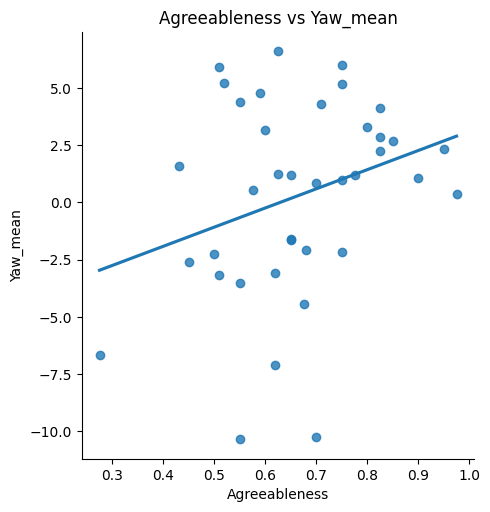

In [32]:
sns.lmplot(x="Agreeableness", y="Yaw_mean", data=merged_head, ci=None)
plt.title("Agreeableness vs Yaw_mean")
plt.show()

###We see a weak trend

Yaw_mean_bin  High  Low
Agree_bin              
High            10    8
Low              9   11


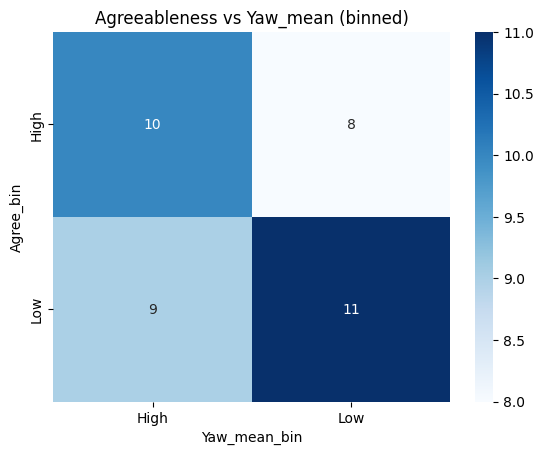

In [33]:
merged_head['Agree_bin'] = np.where(
    merged_head['Agreeableness'] > merged_head['Agreeableness'].median(), "High", "Low"
)
merged_head['Yaw_mean_bin'] = np.where(
    merged_head['Yaw_mean'] > merged_head['Yaw_mean'].median(), "High", "Low"
)

conf = pd.crosstab(merged_head['Agree_bin'], merged_head['Yaw_mean_bin'])
print(conf)

sns.heatmap(conf, annot=True, fmt='d', cmap="Blues")
plt.title("Agreeableness vs Yaw_mean (binned)")
plt.show()

In [35]:
def count_big_events(values, thr=15.0):
    if len(values) <= 1:
        return 0
    arr = np.asarray(values, dtype=float)
    diffs = np.abs(np.diff(arr))
    return int(np.sum(diffs > thr))

events = []
for vid, axes in head_data.items():
    yaw_events   = count_big_events(axes.get('Yaw', []), thr=15)
    pitch_events = count_big_events(axes.get('Pitch', []), thr=10)
    roll_events  = count_big_events(axes.get('Roll', []), thr=10)
    events.append({
        "id_name": vid,
        "Yaw_events": yaw_events,
        "Pitch_events": pitch_events,
        "Roll_events": roll_events
    })

events_df = pd.DataFrame(events)
events_df.head()


,id_name,Yaw_events,Pitch_events,Roll_events
0,byeCjvS_oUH,1,0,0
1,jsjWCIa_tli,0,2,0
2,QYJOylc_eWg,0,0,0
3,gwdnjsF_tFL,0,0,0
4,exSnMmq_NJW,0,0,0


In [36]:
merged_events = pd.merge(vptd_df, events_df, on="id_name", how="inner")

In [38]:
traits = ["Openness","Conscientiousness","Extraversion","Agreeableness","Neuroticism"]

for t in traits:
    print("")
    for ev in ["Yaw_events","Pitch_events","Roll_events"]:
        pear, p1 = pearsonr(merged_events[t], merged_events[ev])
        spear, p2 = spearmanr(merged_events[t], merged_events[ev])
        print(f"{t} vs {ev}: Pearson={pear:.3f}, p={p1:.3f} | Spearman={spear:.3f}, p={p2:.3f}")



Openness vs Yaw_events: Pearson=0.042, p=0.802 | Spearman=-0.026, p=0.878
Openness vs Pitch_events: Pearson=0.181, p=0.278 | Spearman=0.240, p=0.146
Openness vs Roll_events: Pearson=0.051, p=0.763 | Spearman=0.126, p=0.451

Conscientiousness vs Yaw_events: Pearson=0.180, p=0.278 | Spearman=0.024, p=0.888
Conscientiousness vs Pitch_events: Pearson=0.228, p=0.168 | Spearman=0.294, p=0.073
Conscientiousness vs Roll_events: Pearson=0.145, p=0.385 | Spearman=0.137, p=0.412

Extraversion vs Yaw_events: Pearson=0.244, p=0.139 | Spearman=0.055, p=0.745
Extraversion vs Pitch_events: Pearson=0.296, p=0.071 | Spearman=0.236, p=0.153
Extraversion vs Roll_events: Pearson=0.013, p=0.940 | Spearman=-0.010, p=0.951

Agreeableness vs Yaw_events: Pearson=0.281, p=0.088 | Spearman=0.135, p=0.419
Agreeableness vs Pitch_events: Pearson=0.236, p=0.154 | Spearman=0.188, p=0.258
Agreeableness vs Roll_events: Pearson=0.069, p=0.681 | Spearman=0.119, p=0.476

Neuroticism vs Yaw_events: Pearson=-0.212, p=0.201 

Most values are weak, so i can't proove correlations, but we can slightly stronger signals:

**Extraversion vs Pitch_events** → Pearson = 0.296, p = 0.071
Suggests extraverts may nod more (pitch).

**Conscientiousness vs Pitch_events** → Spearman = 0.294, p = 0.073
Possibly more conscientious people show more pitch movements.

**Agreeableness vs Yaw_events** → Pearson = 0.281, p = 0.088
Maybe agreeable people turn heads slightly more.

## Task 3: (5 marks)
Prove the correlation you found between non-verbal cues (smiles and head movements) with personality traits, by training some models to predict the correlated traits depending on the extracted features.

In [39]:
merged_events.head(2)

,id_name,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,SE,Yaw_events,Pitch_events,Roll_events
0,wzewmMk_Nzv,0.56,0.55,0.67,0.62,0.59,2,0,0,0
1,MKdgEMd_con,0.72,0.85,0.77,0.27,0.70,4,0,1,0


In [40]:
merged_all = pd.merge(vptd_df, events_df, on="id_name", how="inner")
merged_all = pd.merge(merged_all, head_df, on="id_name", how="inner")
merged_all = pd.merge(merged_all, smiles_df[['id_name','smiles','total_frames','smile_rate']],
                      on="id_name", how="inner")
merged_all.head(2)

,id_name,Extraversion,Agreeableness,Conscientiousness,Neuroticism,Openness,SE,Yaw_events,Pitch_events,Roll_events,...,Pitch_std,Pitch_min,Pitch_max,Yaw_mean,Yaw_std,Yaw_min,Yaw_max,smiles,total_frames,smile_rate
0,wzewmMk_Nzv,0.56,0.55,0.67,0.62,0.59,2,0,0,0,...,3.157205,-4.89,15.50,4.374791,10.084235,-33.98,20.34,6,790,0.007595
1,MKdgEMd_con,0.72,0.85,0.77,0.27,0.70,4,0,1,0,...,5.068240,-25.94,7.34,2.696723,9.898716,-27.82,31.81,0,3155,0.000000


In [41]:
merged_all.columns.tolist()

['id_name',
 'Extraversion',
 'Agreeableness',
 'Conscientiousness',
 'Neuroticism',
 'Openness',
 'SE',
 'Yaw_events',
 'Pitch_events',
 'Roll_events',
 'Roll_mean',
 'Roll_std',
 'Roll_min',
 'Roll_max',
 'Pitch_mean',
 'Pitch_std',
 'Pitch_min',
 'Pitch_max',
 'Yaw_mean',
 'Yaw_std',
 'Yaw_min',
 'Yaw_max',
 'smiles',
 'total_frames',
 'smile_rate']

For such a tiny dataset it'd be better to use less features

In [42]:
features = [
    "smile_rate",
    "Roll_std","Pitch_std","Yaw_std",
    "Yaw_mean",
    "Yaw_events","Pitch_events","Roll_events"
]

X = merged_all[features]
y = merged_all["Extraversion"]

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

###RandomForest

In [49]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

rf = RandomForestRegressor(
    n_estimators=400, max_depth=None, random_state=42
)
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

rf_r2 = r2_score(y_test, rf_pred)
rf_rmse = mean_squared_error(y_test, rf_pred)
print(f"R2: {rf_r2:.3f} | RMSE: {rf_rmse:.3f}")

R2: -0.194 | RMSE: 0.044


In [50]:
imp = rf.feature_importances_
for f,i in sorted(zip(features, imp), key=lambda t: t[1], reverse=True):
    print(f"{f:15s} {i:.3f}")

smile_rate      0.303
Pitch_std       0.212
Yaw_std         0.150
Roll_std        0.127
Yaw_mean        0.093
Yaw_events      0.058
Pitch_events    0.039
Roll_events     0.019


###XGBoost

In [51]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    objective="reg:squarederror",
    n_estimators=500,
    learning_rate=0.05,
    max_depth=3,
    subsample=0.9,
    colsample_bytree=0.9,
    random_state=42
)
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)

xgb_r2 = r2_score(y_test, xgb_pred)
xgb_rmse = mean_squared_error(y_test, xgb_pred)
print(f"R2: {xgb_r2:.3f} | RMSE: {xgb_rmse:.3f}")

R2: -0.981 | RMSE: 0.072


In [52]:
booster_imp = xgb.feature_importances_
for f,i in sorted(zip(features, booster_imp), key=lambda t: t[1], reverse=True):
    print(f"{f:15s} {i:.3f}")

Pitch_events    0.282
smile_rate      0.204
Roll_events     0.113
Yaw_events      0.105
Pitch_std       0.103
Yaw_mean        0.080
Roll_std        0.067
Yaw_std         0.046


###Expectedly the metrics are bad, but there are little correlations with smiles and pitching

#List of Papers:


1.   http://dx.doi.org/10.23919/FRUCT58615.2023.10143053
2.   http://dx.doi.org/10.3390/data8070113
3.   http://dx.doi.org/10.23919/FRUCT61870.2024.10516365

